In [41]:
FIGURES_PATH = 'out/figures/'
DATASETS_PATH = 'out/datasets/'
DICTS_PATH = 'out/dicts/'
CLUSTERS_PATH = 'out/clusters/'

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import os
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from tqdm.notebook import tqdm
from multiprocesspandas import applyparallel
from pandarallel import pandarallel
import psutil
from sys import getsizeof
import networkx as nx
from scipy.cluster.hierarchy import linkage, fcluster


from netgraph import Graph, InteractiveGraph, EditableGraph

import pickle
import gc 


tqdm.pandas()
from helper import *

In [24]:
NROWS = None

In [25]:
data = pd.read_csv('datasets/чеки.csv', nrows=NROWS)
data = data.rename(columns = {'line_item_id': 'product_id'})

In [26]:
data = data[['line_article_id', 'line_article_description']].drop_duplicates()
product_names = data.set_index('line_article_id').to_dict()['line_article_description']


In [44]:
with open(DICTS_PATH + 'products.json') as json_file:
    products_dict = json.load(json_file)
    
with open(CLUSTERS_PATH + 'dists.pkl', 'rb') as f:
    dists = pickle.load(f)

In [37]:
def concat_dicts(dict1, dict2):
    ans = dict()
    for k1 in dict1.keys():
        if int(k1) in dict2:
            ans[dict1[k1]] = dict2[int(k1)].split()[0]
        else:
            ans[dict1[k1]] = 'Unnamed'
        
    return ans


In [45]:
names = concat_dicts(products_dict, product_names)
names

{0: 'Стремянка',
 1: 'Шпаклёвка',
 2: 'ТРОЙНИК',
 3: 'Гидроизоляция',
 4: 'НАПРЕССОВОЧНАЯ',
 5: 'Клей',
 6: 'БУР',
 7: 'Бетонконтакт',
 8: 'Угол',
 9: 'Заглушка',
 10: 'Кисть',
 11: 'Кисть',
 12: 'ТРУБА',
 13: 'Рулон',
 14: 'Unnamed',
 15: 'Отвод',
 16: 'Пескобетон',
 17: 'Ножницы',
 18: 'Пробка',
 19: 'Диск',
 20: 'Шина',
 21: 'МУФТА',
 22: 'Система',
 23: 'Канал',
 24: 'Отвод',
 25: 'Кисть',
 26: 'УГОЛЬНИК',
 27: 'Тройник',
 28: 'Муфта',
 29: 'Краска',
 30: 'Переход',
 31: 'Паста',
 32: 'Щипцы',
 33: 'Труба',
 34: 'Колено',
 35: 'Выключатель',
 36: 'УГОЛ',
 37: 'Муфта',
 38: 'НЕОДИМОВЫЙ',
 39: 'Мешки',
 40: 'ШТОРА',
 41: 'СКАТЕРТЬ',
 42: 'ОБОИ',
 43: 'КЛЕЙ',
 44: 'Наличник',
 45: 'ДОБОР',
 46: 'Брусок',
 47: 'ФИЛЬТР',
 48: 'Прокладка',
 49: 'Фильтр',
 50: 'Арматура',
 51: 'Unnamed',
 52: 'Батарейка',
 53: 'Решётка',
 54: 'СЧЕТЧИК',
 55: 'ДОРОЖКА',
 56: 'Unnamed',
 57: 'Мешки',
 58: 'LUXENS',
 59: 'ЗАСОВ',
 60: 'Оконный',
 61: 'Перчатки',
 62: 'J-профиль',
 63: 'САЙДИНГ',
 64: 'Заглуш

In [77]:
def visualisation(cluster, dists, product_dict=None, top=10):
    nodes = []
    edges = []
    edge_labels = dict()
    cluster = cluster[:top]
    
    
    a, b = 0.2, 0.7
    
    def dist_between_products(product1, product2):
        if product1 == product2:
            return 0

        if (product1, product2) in dists:
            return dists[(product1, product2)]

        if (product2, product1) in dists:
            return dists[(product2, product1)]

        return float('inf')
    
    def get_dist_between(product, cluster):
        dist = 0.0
        cnt = 0
        for c in cluster:
            if (product, c) in dists:
                dist += dists[(product, c)] ** 2
                cnt += 1
            elif (c, product) in dists:
                dist += dists[(c, product)] ** 2
                cnt += 1
        if cnt == 0:
            return float('inf')
        
        return dist / cnt
    
    nodes = cluster
    
    for p1 in cluster:
        for p2 in cluster:
            if p1 != p2:
                di = dist_between_products(p1, p2)
                if di < float('inf'):
                    edges.append((p1, p2, di))
                    edge_labels[(p1, p2)] = "%.1f" % di
            
            
            
    
            
            
    
    fig = plt.figure(figsize=(20, 10))
    
    weights = np.array([e[2] for e in edges])
    norm = np.linalg.norm(weights)
    node_color = {
#         cluster[0] : 'tab:blue',
    }   
    
    edge_length = dict()
    for e in edges:
        if (e[0], e[1]) not in edge_length:
            length = e[2] / norm # [0, 1]
            length = length * (b - a) + a # [0.3, 0.7]
            edge_length[(e[0], e[1])] = length
            edge_length[(e[1], e[0])] = length
        e = (e[0], e[1], (1 - e[2] / norm) * 30 + 1)
    
        if e[0] not in node_color:
            node_color[e[0]] = 'white'
            
        
        if e[1] not in node_color:
            node_color[e[1]] = 'white'
            
    for p1 in set(np.concatenate(list(edge_length.keys()))):
        for p2 in set(np.concatenate(list(edge_length.keys()))):
            if (p1, p2) not in edge_length:
                edge_length[(p1, p2)] = a
                edge_length[(p2, p1)] = a
        
    
    if product_dict is not None:
        node_labels = dict()
        
        for n in nodes:
            node_labels[n] = product_dict[n]
            
        print(node_labels)
            
        g = Graph(edges,
                  node_color=node_color,
                  node_layout='geometric',
                  node_layout_kwargs=dict(edge_length=edge_length, tol=1e-3),
                  node_size=5,
                  node_label_fontdict={'family': 'serif',
                                       'weight': 'normal',
                                       'size': 16,
                                      },
#                   node_label_offset=0.05,
                  node_alpha=0.4,
                  edge_labels=edge_labels,
                  node_labels=True,
#                   node_labels=node_labels,
                 )
    else:
        g = Graph(edges,
                  node_color=node_color,
                  node_layout='geometric',
                  node_layout_kwargs=dict(edge_length=edge_length, tol=1e-3),
                  node_size=5,
                  node_labels=True,
                  edge_labels=edge_labels,
                 )
    plt.show()

In [78]:
with open(CLUSTERS_PATH + 'k_means.pkl', 'rb') as f:
    clusters = pickle.load(f)
    
with open(CLUSTERS_PATH + 'ward.pkl', 'rb') as f:
    clusters_ward = pickle.load(f)

{12: 'ТРУБА', 28: 'Муфта', 43: 'КЛЕЙ', 49: 'Фильтр', 52: 'Батарейка', 109: 'Сверло', 132: 'ЛАМПАLEDF', 141: 'Крючок', 155: 'МАНЖЕТА', 156: 'ПОЛКОДЕРЖАТЕЛЬ'}


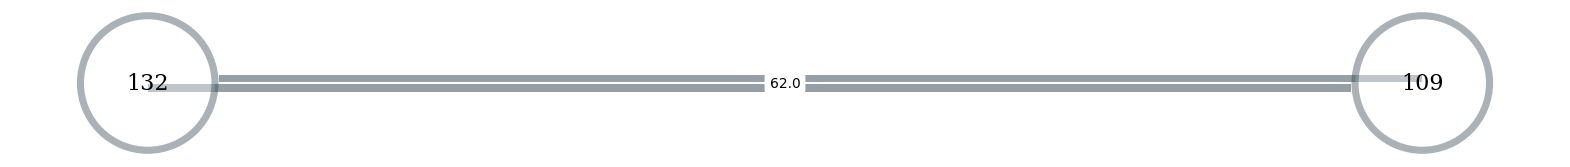

{17: 'Ножницы', 19: 'Диск', 35: 'Выключатель', 48: 'Прокладка', 57: 'Мешки', 71: 'ЛАМПА', 74: 'Насадка', 91: 'Плёнка', 92: 'Плёнка', 100: 'Светильник'}


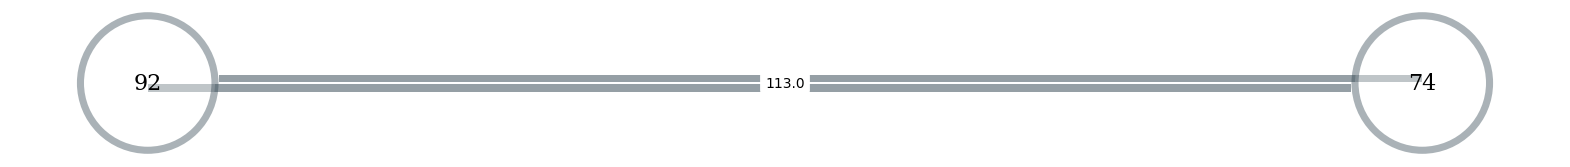

{3: 'Гидроизоляция', 11: 'Кисть', 13: 'Рулон', 22: 'Система', 24: 'Отвод', 25: 'Кисть', 30: 'Переход', 33: 'Труба', 104: 'Набор', 108: 'Бур'}


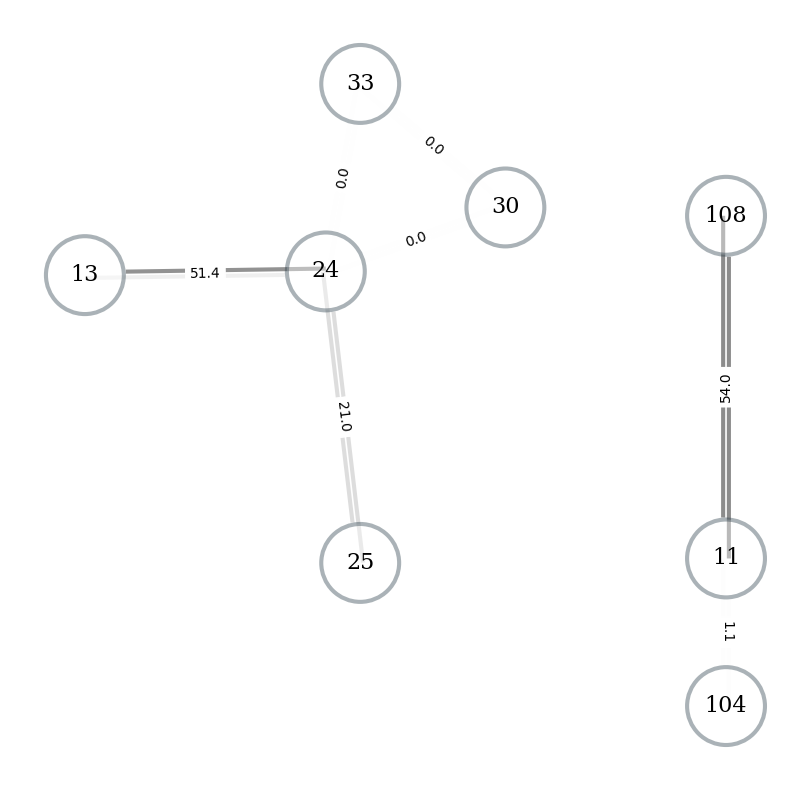

{1: 'Шпаклёвка', 5: 'Клей', 16: 'Пескобетон', 23: 'Канал', 34: 'Колено', 90: 'Пленка', 101: 'Перчатки', 107: 'Тряпки', 163: 'Набор', 177: 'Кювета'}


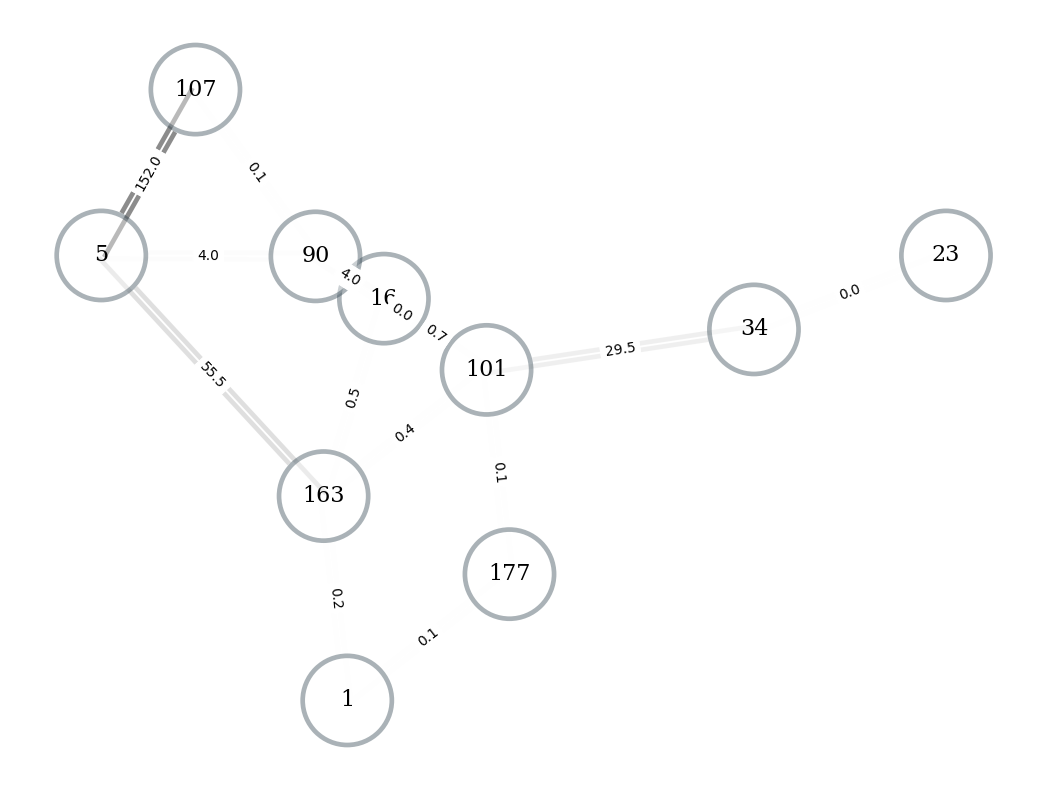

{112: 'Бур', 390: 'Комплект', 480: 'Заглушка', 481: 'Рельс', 482: 'Держатель', 485: 'Направляющая', 486: 'Кронштейн', 1016: 'Картонная', 1325: 'Лампа', 1842: 'Комплект'}


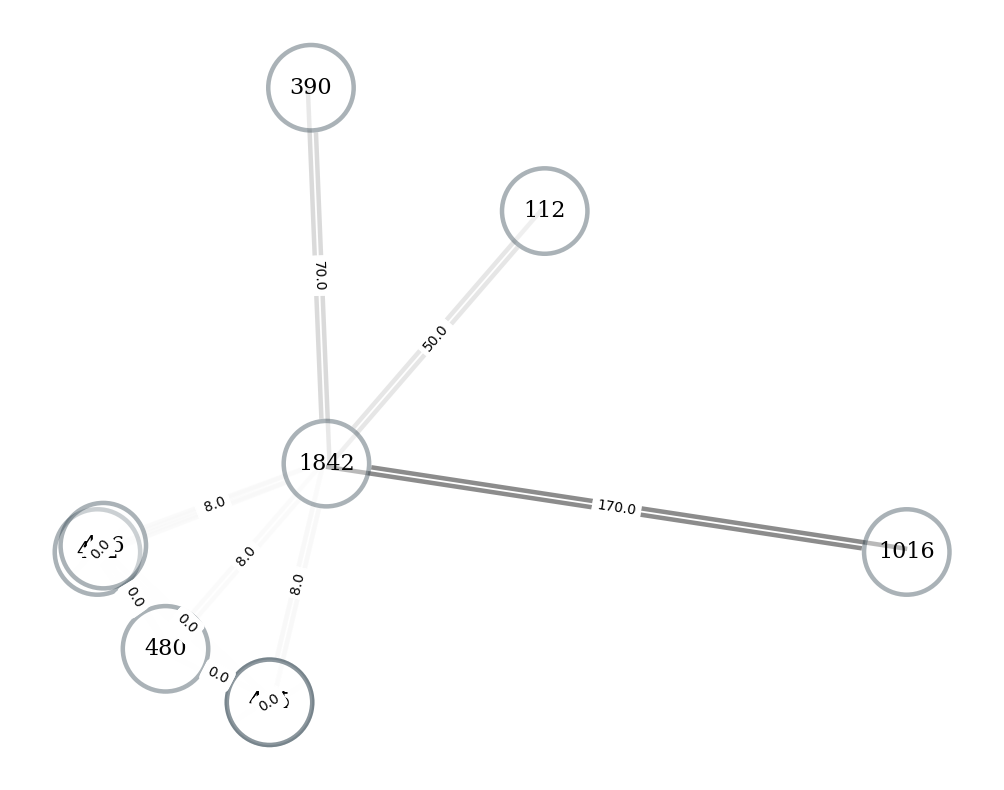

In [79]:
for c in sorted(clusters_ward, key=(lambda x: len(x)), reverse=True)[:5]:
    visualisation(c, dists, product_dict=names,top=10)